## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [20]:
# pandas and numpy
import pandas as pd
import numpy as np

# emoji for preprocessing
#!pip install emoji
import emoji

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [22]:
## limiting sample to 5000 tweets (large enough to hopefully catch most oddities) 
congress_tweets_sample = congress_tweets.sample(n=5000)

#visualizing column
congress_tweets_sample['text']

343196    Pleased to announce @KUMedCenter will be recei...
94303     PG&amp;E has proactively isolated a gas transm...
667279    RT @EnergyCommerce We couldn’t agree more, Mr....
781134    About to go on- tune in at 9:00am! https://twi...
761262    I also enjoyed our visit. Thank you, @ChadWilb...
                                ...                        
569573    Could today be the beginning of the end for th...
155698    I’m wishing those celebrating the first night ...
883643    The IRS released new projections that suggest ...
378954    I fought @realDonaldTrump's efforts to elimina...
805833    legislation that will provide immediate relief...
Name: text, Length: 5000, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [23]:
def rem_punc_stop(text):
    # set objects
    stop_words = STOP_WORDS
    additional_stops = {'u', 'e', 'eHouse'} # I identified these after creating a few wordclouds iteratively
    stop_words.update(additional_stops)
    punc = set(punctuation)
    
    # First split into words
    words = text.split()
    cleaned_words = []
    i = 0
    
    while i < len(words):
        # Remove RT/QT and skip the next word (username) if it's a retweet/quote tweet pattern
        if (i < len(words) - 1 and 
            (words[i] == "RT" or words[i] == "QT") and 
            words[i + 1].startswith("@")):
            i += 2  # Skip both RT/QT and the @username
        # Remove any @username mentions
        elif words[i].startswith("@"):
            i += 1  # Skip the @username
        # Remove standalone RT, QT
        elif words[i] in ["RT", "QT"]:
            i += 1
        else:
            cleaned_words.append(words[i])
            i += 1
    
    # Join back into text
    text = " ".join(cleaned_words)
    
    # remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # remove emojis using emoji library
    punc_free = emoji.replace_emoji(punc_free, '')
    
    # remove URL
    words = punc_free.split()
    punc_free = " ".join([word for word in words if not word.startswith(('http', 'https', 'www'))])
    
    # Remove extra whitespace created by removals
    punc_free = " ".join(punc_free.split())
    
    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text
    spacy_words = [token.text for token in doc]
    
    # filter out words
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # Remove 'amp' from the word list (identified after initial cleaning and making a wordcloud; doubled back to remove
    no_punc = [word for word in spacy_words if word not in stop_words and word != 'amp']
    
    # return
    return no_punc

In [24]:
# Test on one tweet
sample_tweet = congress_tweets_sample['text'].iloc[0]
print("Original:", sample_tweet)
print("Processed:", rem_punc_stop(sample_tweet))

Original: Pleased to announce @KUMedCenter will be receiving $5M from @NIH to improve #COVID19 testing in underserved &amp; vulnerable populations as part of #RADx. They have strong community partnerships, making them an ideal participant to learn how we can better serve these populations.
Processed: ['Pleased', 'announce', 'receiving', '5', 'M', 'improve', 'COVID19', 'testing', 'underserved', 'vulnerable', 'populations', 'RADx', 'They', 'strong', 'community', 'partnerships', 'making', 'ideal', 'participant', 'learn', 'better', 'serve', 'populations']


In [25]:
# apply function to the 'text' column in the sample rows from the dataset
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))

# visualize
congress_tweets_sample['tokens']

343196    [Pleased, announce, receiving, 5, M, improve, ...
94303     [PGampE, proactively, isolated, gas, transmiss...
667279    [We, agree, Mr, And, exactly, HR, 3, Let, bipa...
781134    [About, tune, 900am, On, MemberFocusMonday, jo...
761262    [I, enjoyed, visit, Thank, Enjoyed, visiting, ...
                                ...                        
569573    [Could, today, beginning, end, Buffalo, Skyway...
155698    [I, wishing, celebrating, night, Hanukkah, joy...
883643    [The, IRS, released, new, projections, suggest...
378954    [I, fought, efforts, eliminate, federal, budge...
805833    [legislation, provide, immediate, relief, Amer...
Name: tokens, Length: 5000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

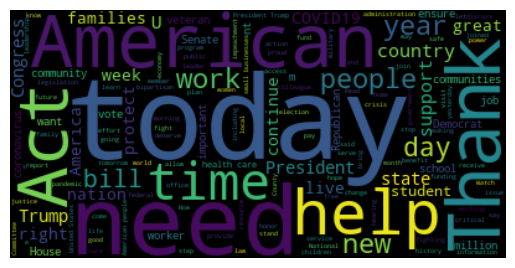

In [26]:
# General Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ----------
# apply function to text object
text = ' '.join(congress_tweets_sample['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

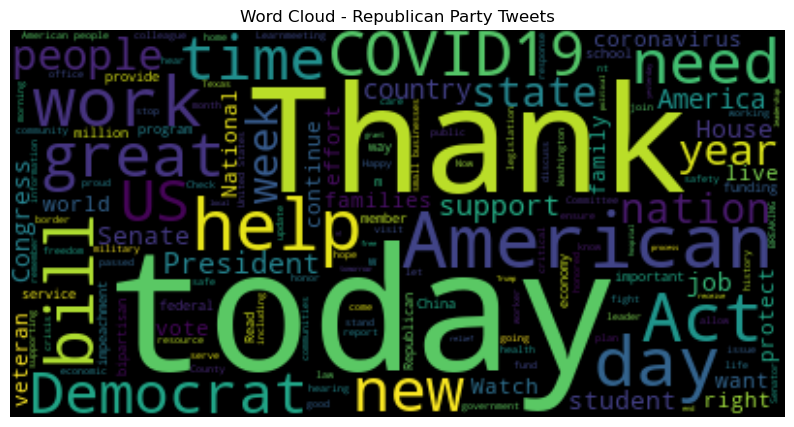

In [27]:
# Wordcloud for individuals whose party is republican
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Filter the dataframe to include only Republican party members
republican_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Republican']

# Join the tokens for Republican tweets
republican_text = ' '.join(republican_tweets['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud visualization for Republican tweets
republican_wordcloud = WordCloud(random_state=40).generate(republican_text)  # set random state to ensure same word cloud each time

# Plot
plt.figure(figsize=(10, 8))  # Optional: set figure size for better visibility
plt.imshow(republican_wordcloud, 
           interpolation = 'bilinear')  # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title('Word Cloud - Republican Party Tweets')  # Optional: add a title
plt.show()                             # show the plot

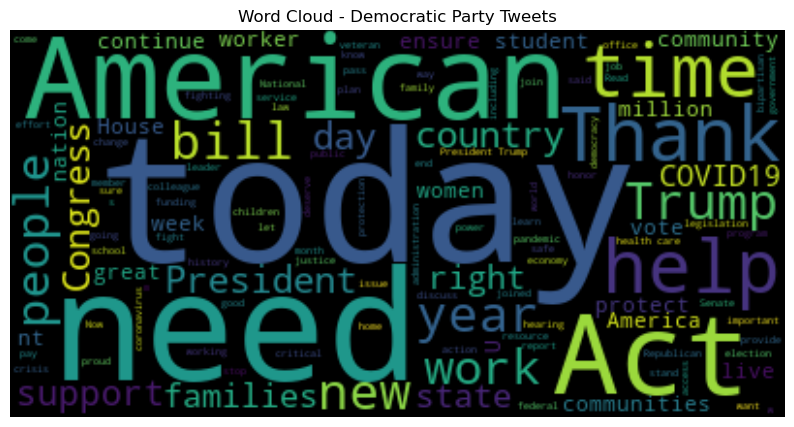

In [28]:
# Wordcloud for individuals whose party is democrat
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Filter the dataframe to include only Republican party members
democrat_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Democrat']

# Join the tokens for Republican tweets
democrat_text = ' '.join(democrat_tweets['tokens'].map(lambda text: ' '.join(text)))

# Create WordCloud visualization for Democrat tweets
democrat_wordcloud = WordCloud(random_state=40).generate(democrat_text)  # set random state to ensure same word cloud each time

# Plot
plt.figure(figsize=(10, 8))  # Optional: set figure size for better visibility
plt.imshow(democrat_wordcloud, 
           interpolation = 'bilinear')  # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title('Word Cloud - Democratic Party Tweets')  # Optional: add a title
plt.show()                             # show the plot

### EDA 2

In [29]:
# Lengths and counts for overall tweets
# create new feature columns with counts of # of characters and # of words
# ---------------
# count of number of characters
congress_tweets_sample['tweet_char'] = congress_tweets_sample['text'].apply(len)
# count of number of words
congress_tweets_sample['word_count'] = congress_tweets_sample['text'].apply(lambda x: len(str(x).split()))


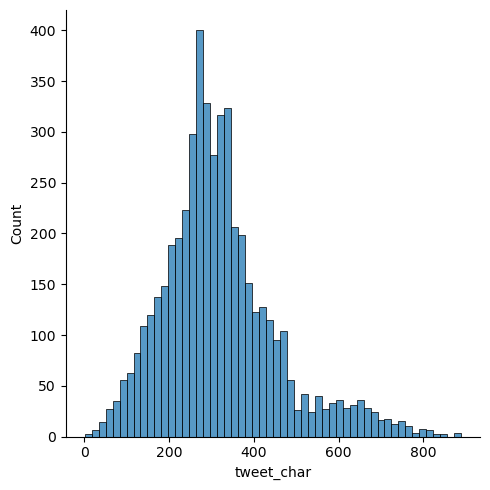

In [30]:
# create histogram of general tweet character length (number of characters)
sns.displot(congress_tweets_sample, # specify data
            x="tweet_char")         # x-axis feature
plt.show()

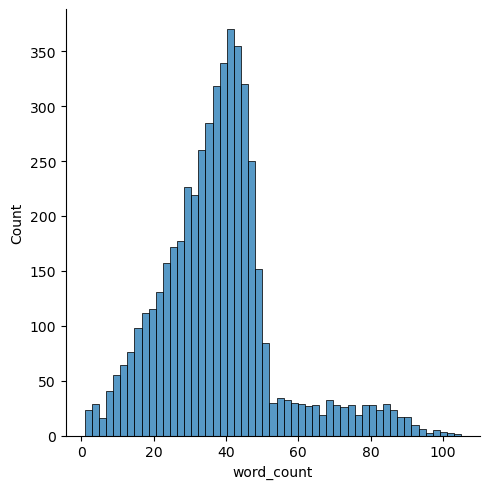

In [31]:
# create histogram of general word count 
sns.displot(congress_tweets_sample, # specify data
            x="word_count")         # x-axis feature
plt.show()

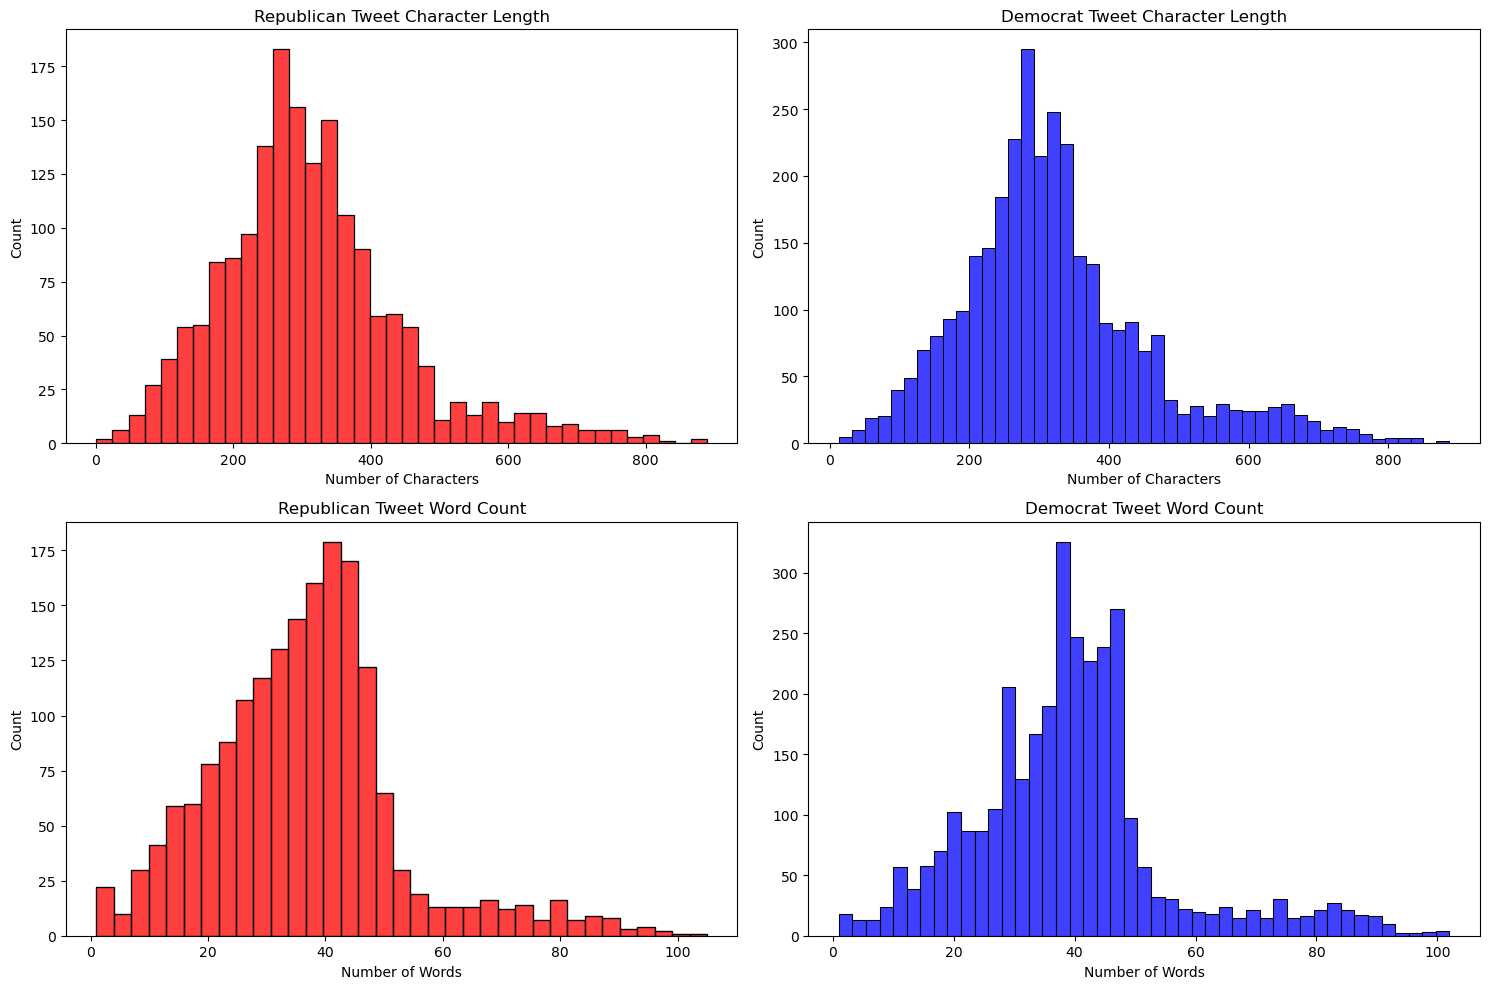

In [32]:
# Create historgrams for Democrats and Republicans
# ----
# Filter data for Republicans and Democrats
republican_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Republican']
democrat_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Democrat']

# Create figure with subplots - 2 rows (character length, word count) and 2 columns (Republican, Democrat)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length histograms
sns.histplot(republican_tweets, x="tweet_char", ax=axes[0, 0], color='red')
axes[0, 0].set_title('Republican Tweet Character Length')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Count')

sns.histplot(democrat_tweets, x="tweet_char", ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Democrat Tweet Character Length')
axes[0, 1].set_xlabel('Number of Characters')
axes[0, 1].set_ylabel('Count')

# Word count histograms
sns.histplot(republican_tweets, x="word_count", ax=axes[1, 0], color='red')
axes[1, 0].set_title('Republican Tweet Word Count')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Count')

sns.histplot(democrat_tweets, x="word_count", ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Democrat Tweet Word Count')
axes[1, 1].set_xlabel('Number of Words')
axes[1, 1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [33]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
congress_tweets_sample['tokens'] = congress_tweets_sample['tokens'].map(lambda text: ' '.join(text))

# create "polarity" column 
congress_tweets_sample['polarity'] = congress_tweets_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

In [34]:
# Create a column for subjectivity
# ------
congress_tweets_sample['subjectivity'] = congress_tweets_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
congress_tweets_sample.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tweet_char,word_count,polarity,subjectivity
343196,1.311680e+18,JerryMoran,2020-10-01T10:58:08-04:00,Pleased to announce @KUMedCenter will be recei...,Jerry Moran,Sen,3-Jan-11,5/29/1954,M,KS,...,Republican,"671,018","427,005","440,726","692,634",Pleased announce receiving 5 M improve COVID19...,280,42,0.366667,0.746667
94303,1.188530e+18,RepHuffman,2019-10-27T15:04:47-04:00,PG&amp;E has proactively isolated a gas transm...,Jared Huffman,Rep,3-Jan-13,2/18/1964,M,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",PGampE proactively isolated gas transmission l...,200,30,-0.400000,0.600000
667279,1.205180e+18,RepSchrader,2019-12-12T12:31:01-05:00,"RT @EnergyCommerce We couldn’t agree more, Mr....",Kurt Schrader,Rep,3-Jan-09,10/19/1951,M,OR,...,Democrat,"782,403","1,002,106","970,488","754,175",We agree Mr And exactly HR 3 Let bipartisan fa...,183,24,0.250000,0.250000
781134,1.165990e+18,RepFletcher,2019-08-26T09:55:30-04:00,About to go on- tune in at 9:00am! https://twi...,Lizzie Fletcher,Rep,3-Jan-19,2/13/1975,F,TX,...,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",About tune 900am On MemberFocusMonday joined C...,337,36,0.000000,0.250000
761262,1.092540e+18,RepChipRoy,2019-02-04T16:46:50-05:00,"I also enjoyed our visit. Thank you, @ChadWilb...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",I enjoyed visit Thank Enjoyed visiting flight ...,232,24,0.500000,0.700000


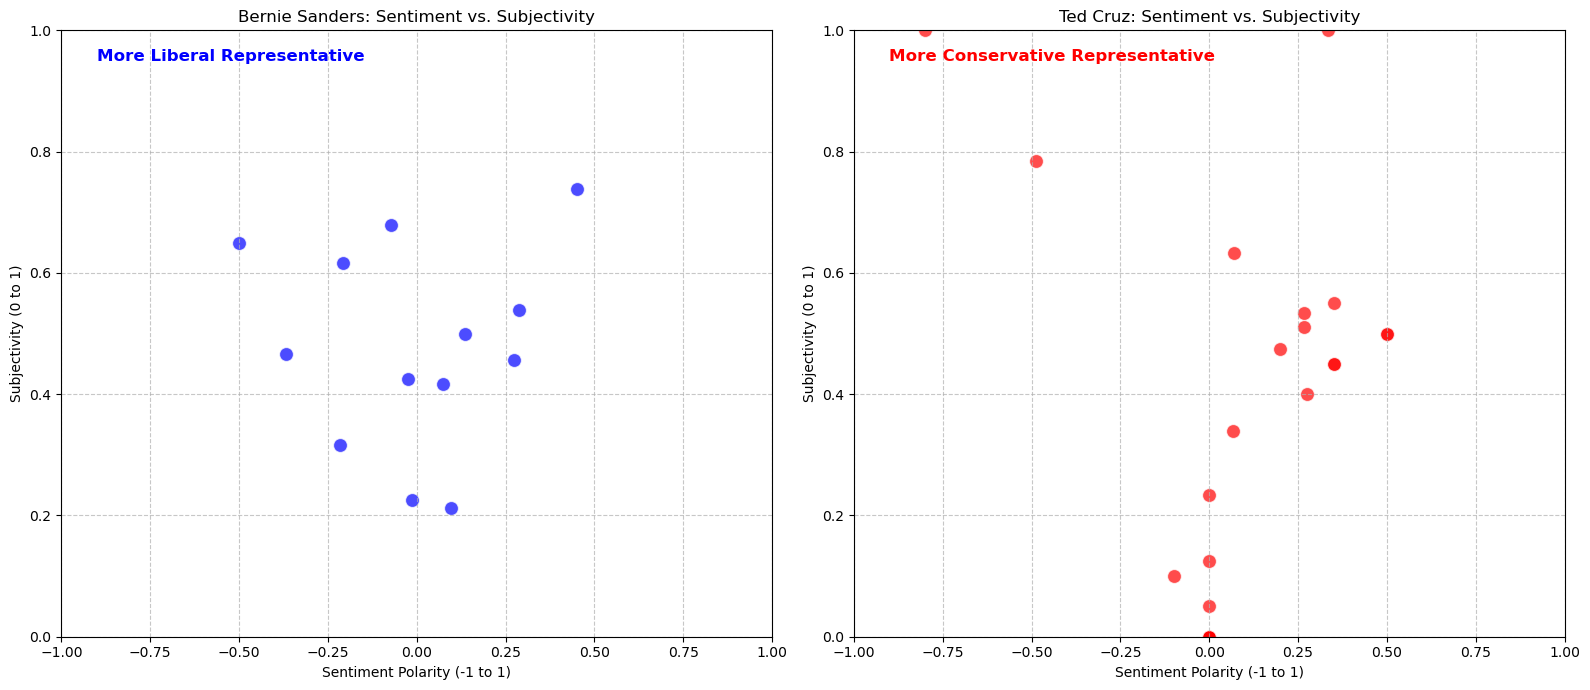

In [35]:
# Polarity vs. subjectivity scatterplots for Bernie Sanders and Ted Cruz

# Filter for Bernie Sanders and Ted Cruz based on screen_name as shown in your code
sanders_tweets = congress_tweets_sample[congress_tweets_sample['screen_name'] == 'SenSanders']
cruz_tweets = congress_tweets_sample[congress_tweets_sample['screen_name'] == 'SenTedCruz']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Scatterplot for Bernie Sanders
sns.scatterplot(
    data=sanders_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax1,
    color='blue',
    alpha=0.7,
    s=100  # slightly larger point size for better visibility
)
ax1.set_title('Bernie Sanders: Sentiment vs. Subjectivity')
ax1.set_xlabel('Sentiment Polarity (-1 to 1)')
ax1.set_ylabel('Subjectivity (0 to 1)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add text to highlight that Bernie Sanders is more liberal
ax1.text(0.05, 0.95, "More Liberal Representative", transform=ax1.transAxes, 
         fontsize=12, fontweight='bold', color='blue')

# Scatterplot for Ted Cruz
sns.scatterplot(
    data=cruz_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax2,
    color='red',
    alpha=0.7,
    s=100  # slightly larger point size for better visibility
)
ax2.set_title('Ted Cruz: Sentiment vs. Subjectivity')
ax2.set_xlabel('Sentiment Polarity (-1 to 1)')
ax2.set_ylabel('Subjectivity (0 to 1)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add text to highlight that Ted Cruz is more conservative
ax2.text(0.05, 0.95, "More Conservative Representative", transform=ax2.transAxes, 
         fontsize=12, fontweight='bold', color='red')

# Ensure both plots have the same scale for fair comparison
# Set the limits based on reasonable sentiment and subjectivity ranges
for ax in [ax1, ax2]:
    ax.set_xlim(-1, 1)  # Sentiment polarity typically ranges from -1 to 1
    ax.set_ylim(0, 1)   # Subjectivity typically ranges from 0 to 1

# Adjust layout
plt.tight_layout()
plt.show()


The above scatterplots show that Tex Cruz's tweets appear to skew more between neutral and positive sentiment polarity, whereas Bernie Sanders' tweets appear to skew more between neutral and negative sentiment polarity. They both appear to have similar spread in subjectivity. Bernie Sanders' results are not surprising as he is known for being extremely outspoken in his negative criticisms of issues, politicians, and government overall. I was surprised that Ted Cruz's tweets tend to skew towards positive sentiment polarity, however, as I don't necessarily think of him as being a positive person, and is often highly critical of liberal politicians. 

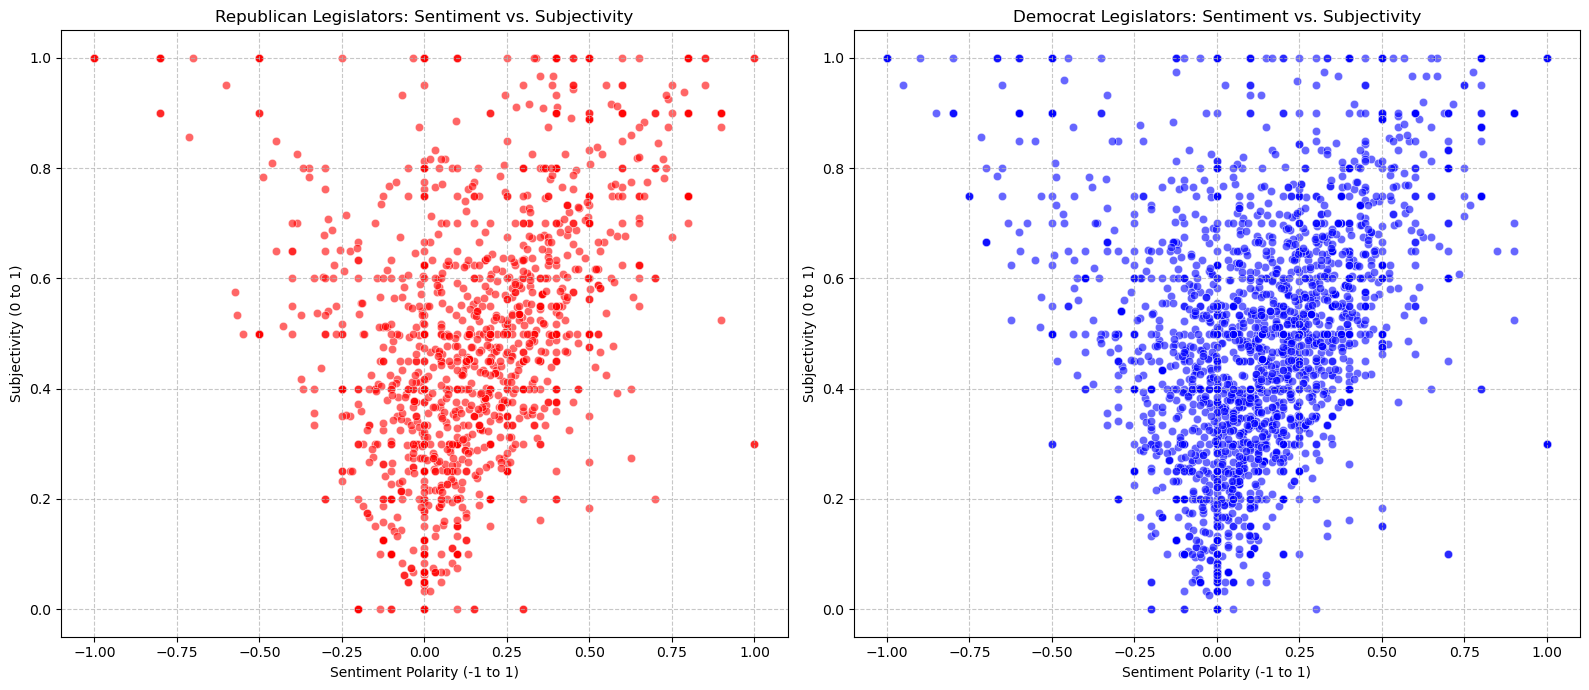

In [36]:
# Scatterplots for republicans vs. democrats

# Get unique party values to make sure we're filtering correctly
# Uncomment this line if you need to check what values exist in the party column
# print(congress_tweets_sample['party'].unique())

# Filter the dataframe by party
republican_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Republican']
democrat_tweets = congress_tweets_sample[congress_tweets_sample['party'] == 'Democrat']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Scatterplot for Republicans
sns.scatterplot(
    data=republican_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax1,
    color='red',
    alpha=0.6
)
ax1.set_title('Republican Legislators: Sentiment vs. Subjectivity')
ax1.set_xlabel('Sentiment Polarity (-1 to 1)')
ax1.set_ylabel('Subjectivity (0 to 1)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Scatterplot for Democrats
sns.scatterplot(
    data=democrat_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax2,
    color='blue',
    alpha=0.6
)
ax2.set_title('Democrat Legislators: Sentiment vs. Subjectivity')
ax2.set_xlabel('Sentiment Polarity (-1 to 1)')
ax2.set_ylabel('Subjectivity (0 to 1)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

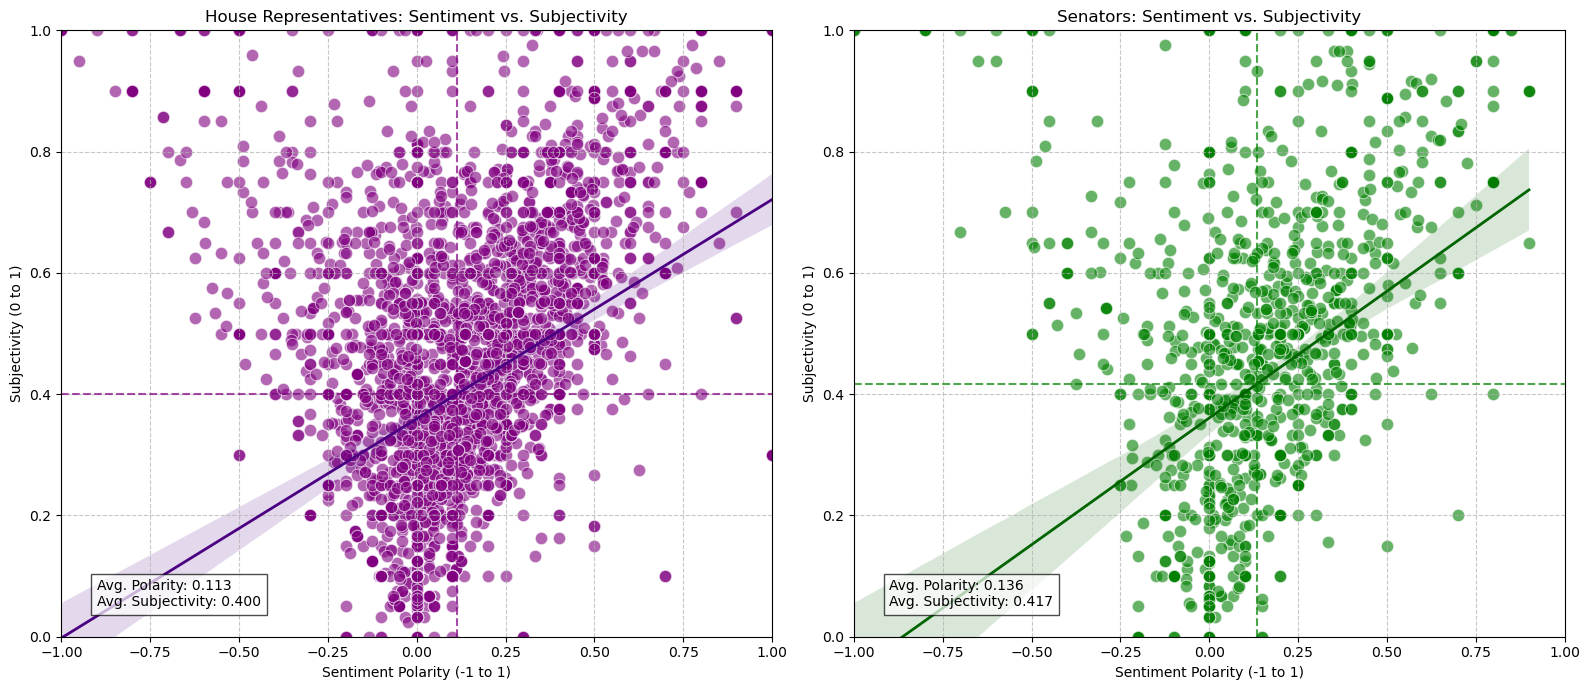

In [37]:
# Create scatterplots for Representatives vs Senators (sentiment polarity vs. subjectivity)

# Filter for Representatives and Senators based on the 'position' column
rep_tweets = congress_tweets_sample[congress_tweets_sample['position'] == 'Rep']
sen_tweets = congress_tweets_sample[congress_tweets_sample['position'] == 'Sen']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Scatterplot for Representatives
sns.scatterplot(
    data=rep_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax1,
    color='purple',
    alpha=0.6,
    s=80  # point size
)

# Add trendline directly to the first axis
sns.regplot(x='polarity', y='subjectivity', data=rep_tweets, ax=ax1, 
            scatter=False, color='indigo', line_kws={'linewidth': 2})

ax1.set_title('House Representatives: Sentiment vs. Subjectivity')
ax1.set_xlabel('Sentiment Polarity (-1 to 1)')
ax1.set_ylabel('Subjectivity (0 to 1)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Scatterplot for Senators
sns.scatterplot(
    data=sen_tweets,
    x='polarity',
    y='subjectivity',
    ax=ax2,
    color='green',
    alpha=0.6,
    s=80  # point size
)

# Add trendline directly to the second axis
sns.regplot(x='polarity', y='subjectivity', data=sen_tweets, ax=ax2, 
            scatter=False, color='darkgreen', line_kws={'linewidth': 2})

ax2.set_title('Senators: Sentiment vs. Subjectivity')
ax2.set_xlabel('Sentiment Polarity (-1 to 1)')
ax2.set_ylabel('Subjectivity (0 to 1)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Ensure both plots have the same scale for fair comparison
for ax in [ax1, ax2]:
    ax.set_xlim(-1, 1)  # Sentiment polarity typically ranges from -1 to 1
    ax.set_ylim(0, 1)   # Subjectivity typically ranges from 0 to 1

# Show average values as vertical and horizontal lines
ax1.axvline(x=rep_tweets['polarity'].mean(), color='purple', linestyle='--', alpha=0.7)
ax1.axhline(y=rep_tweets['subjectivity'].mean(), color='purple', linestyle='--', alpha=0.7)
ax2.axvline(x=sen_tweets['polarity'].mean(), color='green', linestyle='--', alpha=0.7)
ax2.axhline(y=sen_tweets['subjectivity'].mean(), color='green', linestyle='--', alpha=0.7)

# Add text annotations showing the means
ax1.text(0.05, 0.05, f"Avg. Polarity: {rep_tweets['polarity'].mean():.3f}\nAvg. Subjectivity: {rep_tweets['subjectivity'].mean():.3f}", 
         transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
ax2.text(0.05, 0.05, f"Avg. Polarity: {sen_tweets['polarity'].mean():.3f}\nAvg. Subjectivity: {sen_tweets['subjectivity'].mean():.3f}", 
         transform=ax2.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Adjust layout
plt.tight_layout()

# Show the figure 
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [61]:
# 1. Features engineered from previous analysis

# Create a dataframe with engineered features
engineered_features = congress_tweets_sample[['tweet_char', 'word_count', 'polarity', 'subjectivity']].copy()

# Add new features based on previous analysis

# Ratio of characters to words (complexity measure)
engineered_features['avg_word_length'] = congress_tweets_sample['tweet_char'] / congress_tweets_sample['word_count']

# Create categorical features
engineered_features['polarity_category'] = pd.cut(congress_tweets_sample['polarity'], 
                                                 bins=[-1, -0.5, 0, 0.5, 1], 
                                                 labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])

engineered_features['subjectivity_category'] = pd.cut(congress_tweets_sample['subjectivity'],
                                                     bins=[0, 0.33, 0.67, 1],
                                                     labels=['Objective', 'Neutral', 'Subjective'])

# Add party and position from original dataframe if available
if 'party' in congress_tweets_sample.columns:
    engineered_features['party'] = congress_tweets_sample['party']
if 'position' in congress_tweets_sample.columns:
    engineered_features['position'] = congress_tweets_sample['position']

engineered_features

,tweet_char,word_count,polarity,subjectivity,avg_word_length,polarity_category,subjectivity_category,party,position
343196,280,42,0.366667,0.746667,6.666667,Positive,Subjective,Republican,Sen
94303,200,30,-0.400000,0.600000,6.666667,Negative,Neutral,Democrat,Rep
667279,183,24,0.250000,0.250000,7.625000,Positive,Objective,Democrat,Rep
781134,337,36,0.000000,0.250000,9.361111,Negative,Objective,Democrat,Rep
761262,232,24,0.500000,0.700000,9.666667,Positive,Subjective,Republican,Rep
...,...,...,...,...,...,...,...,...,...
569573,126,16,0.000000,0.000000,7.875000,Negative,NaN,Democrat,Rep
155698,257,46,0.316667,0.633333,5.586957,Positive,Neutral,Democrat,Rep
883643,303,44,0.318182,0.477273,6.886364,Positive,Neutral,Democrat,Rep
378954,379,42,0.200000,0.300000,9.023810,Positive,Objective,Democrat,Rep


### Bag-of-words or Tf-idf

In [60]:
# 2. Frequency Based featurization: TF-IDF Matrix
# Use the already tokenized data and join tokens back into strings for TF-IDF
# First check if we need to convert tokens to strings
token_type = type(congress_tweets_sample['tokens'].iloc[0])
if token_type == list:
    # If tokens are stored as lists, join them into strings
    text_for_tfidf = congress_tweets_sample['tokens'].apply(lambda x: ' '.join(x))
else:
    # If tokens are already strings, use them directly
    text_for_tfidf = congress_tweets_sample['tokens']

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(text_for_tfidf)

# Convert to DataFrame for easier inspection
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df

,10,100,11,12,13,14,15,20,2019,2020,...,wrong,wrote,year,years,yes,yesterday,york,you,young,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.223051,0.0,0.000000,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.198218,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Word Embedding

In [40]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

# model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

I was having trouble using the model from Google, so I decided to train Word2Vec on my on text, as we did in lab. Code below.

In [53]:
# apply CBOW Word2vec model to congress_tweets_sample data 
# ----------
model = gensim.models.Word2Vec(congress_tweets_sample['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [56]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.key_to_index]
    return np.mean(model[doc], axis=0)

In [58]:
# Apply function to text

# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for puppy in congress_tweets_sample['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model.wv, puppy))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[ 0.02095236,  0.1619456 ,  0.00399897, ..., -0.04679919,
         0.27420899,  0.21285106],
       [-0.02087727,  0.11357488, -0.00241303, ..., -0.10142285,
         0.28025794,  0.2390908 ],
       [-0.04186304,  0.08249813,  0.00459077, ..., -0.08675865,
         0.25721481,  0.14389443],
       ...,
       [-0.01509194,  0.17291363,  0.04517401, ..., -0.07396178,
         0.26233891,  0.20748524],
       [ 0.01327533,  0.14635673,  0.01477056, ..., -0.10258393,
         0.27328977,  0.2164025 ],
       [-0.04636965,  0.17168353,  0.05061272, ..., -0.10193031,
         0.26436704,  0.21076643]])

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [77]:
# Load libraries for classification using logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Engineered text features

#### Model to predict Democrat or Republican

In [78]:
engineered_features.head()

,tweet_char,word_count,polarity,subjectivity,avg_word_length,polarity_category,subjectivity_category,party,position
343196,280,42,0.366667,0.746667,6.666667,Positive,Subjective,0,Sen
94303,200,30,-0.400000,0.600000,6.666667,Negative,Neutral,1,Rep
667279,183,24,0.250000,0.250000,7.625000,Positive,Objective,1,Rep
781134,337,36,0.000000,0.250000,9.361111,Negative,Objective,1,Rep
761262,232,24,0.500000,0.700000,9.666667,Positive,Subjective,0,Rep


In [79]:
# Preprocessing for logistic model
# ------
# Target
lb = LabelBinarizer()
y_et = engineered_features['party'] = lb.fit_transform(engineered_features['party'])

# Features

X_et_prep = engineered_features.drop(['party'], axis = 1)
X_et = pd.get_dummies(X_et_prep)
X_et.head()

,tweet_char,word_count,polarity,subjectivity,avg_word_length,polarity_category_Very Negative,polarity_category_Negative,polarity_category_Positive,polarity_category_Very Positive,subjectivity_category_Objective,subjectivity_category_Neutral,subjectivity_category_Subjective,position_Rep,position_Sen
343196,280,42,0.366667,0.746667,6.666667,False,False,True,False,False,False,True,False,True
94303,200,30,-0.400000,0.600000,6.666667,False,True,False,False,False,True,False,True,False
667279,183,24,0.250000,0.250000,7.625000,False,False,True,False,True,False,False,True,False
781134,337,36,0.000000,0.250000,9.361111,False,True,False,False,True,False,False,True,False
761262,232,24,0.500000,0.700000,9.666667,False,False,True,False,False,False,True,True,False


In [84]:
# 1. Split data into train+validation and test sets (80/20)
X_train_val_et, X_test_et, y_train_val_et, y_test_et = train_test_split(
    X_et, y_et, test_size=0.2, random_state=42)

# 2. Further split train+validation into train and validation sets (75/25, resulting in 60/20/20 overall)
X_train_et, X_val_et, y_train_et, y_val_et = train_test_split(
    X_train_val_et, y_train_val_et, test_size=0.25, random_state=42)

# 3. Standardize each set separately, fitting only on training data
scaler_et = StandardScaler()
X_train_scaled_et = scaler_et.fit_transform(X_train_et)
X_val_scaled_et = scaler_et.transform(X_val_et)  # Use training params
X_test_scaled_et = scaler_et.transform(X_test_et)  # Use training params

# Convert back to DataFrames to keep column names
X_train_scaled_et = pd.DataFrame(X_train_scaled_et, columns=X_et.columns)
X_val_scaled_et = pd.DataFrame(X_val_scaled_et, columns=X_et.columns)
X_test_scaled_et = pd.DataFrame(X_test_scaled_et, columns=X_et.columns)

# 4. Train model on training data with default hyperparameters
log_reg_et = LogisticRegression(max_iter=1000, random_state=42)
log_reg_et.fit(X_train_scaled_et, y_train_et.ravel())

LogisticRegression(max_iter=1000, random_state=42)

In [92]:
# 5. Evaluate on validation data
y_val_pred_et = log_reg_et.predict(X_val_scaled_et)
val_accuracy_et = accuracy_score(y_val_et, y_val_pred_et)
print(f"Validation Accuracy (ET party): {val_accuracy_et:.4f}")
print("\nValidation Classification Report (ET party):")
print(classification_report(y_val_et, y_val_pred_et))

# 6. Train final model on combined train+validation data
# Combine train and validation data
X_train_val_scaled_et = pd.concat([X_train_scaled_et, X_val_scaled_et])
y_train_val_combined_et = np.concatenate((y_train_et, y_val_et))

# Train final model
final_model_et = LogisticRegression(max_iter=1000, random_state=42)
final_model_et.fit(X_train_val_scaled_et, y_train_val_combined_et)


Validation Accuracy (ET party): 0.6500

Validation Classification Report (ET party):
              precision    recall  f1-score   support

           0       0.55      0.16      0.24       360
           1       0.66      0.93      0.77       640

    accuracy                           0.65      1000
   macro avg       0.61      0.54      0.51      1000
weighted avg       0.62      0.65      0.58      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

In [93]:
# 7. Evaluate on test data
y_test_pred_et = final_model_et.predict(X_test_scaled_et)
test_accuracy_et = accuracy_score(y_test_et, y_test_pred_et)
print(f"\nTest Accuracy (ET party): {test_accuracy_et:.4f}")
print("\nTest Classification Report (ET party):")
print(classification_report(y_test_et, y_test_pred_et))
print("\nConfusion Matrix (ET party):")
print(confusion_matrix(y_test_et, y_test_pred_et))

# 8. Feature importance
feature_importance_et = pd.DataFrame({
    'Feature': X_et.columns,
    'Importance': np.abs(final_model_et.coef_[0])
})
feature_importance_et = feature_importance_et.sort_values('Importance', ascending=False)
print("\nFeature Importance (ET party):")
print(feature_importance_et)


Test Accuracy (ET party): 0.6600

Test Classification Report (ET party):
              precision    recall  f1-score   support

           0       0.57      0.12      0.19       350
           1       0.67      0.95      0.78       650

    accuracy                           0.66      1000
   macro avg       0.62      0.53      0.49      1000
weighted avg       0.63      0.66      0.58      1000


Confusion Matrix (ET party):
[[ 41 309]
 [ 31 619]]

Feature Importance (ET party):
                             Feature  Importance
1                         word_count    0.258663
3                       subjectivity    0.137674
13                      position_Sen    0.137636
12                      position_Rep    0.137636
0                         tweet_char    0.120223
2                           polarity    0.119859
11  subjectivity_category_Subjective    0.106568
10     subjectivity_category_Neutral    0.084163
4                    avg_word_length    0.029002
7         polarity_categ

#### Model to predict Senator or Representative

In [88]:
# Preprocessing for logistic model
# ------
# Target
lb = LabelBinarizer()
y_et_pos = engineered_features['position'] = lb.fit_transform(engineered_features['position'])

# Features

X_et_pos_prep = engineered_features.drop(['position'], axis = 1)
X_et_pos = pd.get_dummies(X_et_pos_prep)
X_et_pos.head()

,tweet_char,word_count,polarity,subjectivity,avg_word_length,party,polarity_category_Very Negative,polarity_category_Negative,polarity_category_Positive,polarity_category_Very Positive,subjectivity_category_Objective,subjectivity_category_Neutral,subjectivity_category_Subjective
343196,280,42,0.366667,0.746667,6.666667,0,False,False,True,False,False,False,True
94303,200,30,-0.400000,0.600000,6.666667,1,False,True,False,False,False,True,False
667279,183,24,0.250000,0.250000,7.625000,1,False,False,True,False,True,False,False
781134,337,36,0.000000,0.250000,9.361111,1,False,True,False,False,True,False,False
761262,232,24,0.500000,0.700000,9.666667,0,False,False,True,False,False,False,True


In [89]:
# 1. Split data into train+validation and test sets (80/20)
X_train_val_et_pos, X_test_et_pos, y_train_val_et_pos, y_test_et_pos = train_test_split(
    X_et_pos, y_et_pos, test_size=0.2, random_state=42)

# 2. Further split train+validation into train and validation sets (75/25, resulting in 60/20/20 overall)
X_train_et_pos, X_val_et_pos, y_train_et_pos, y_val_et_pos = train_test_split(
    X_train_val_et_pos, y_train_val_et_pos, test_size=0.25, random_state=42)

# 3. Standardize each set separately, fitting only on training data
scaler_et_pos = StandardScaler()
X_train_scaled_et_pos = scaler_et_pos.fit_transform(X_train_et_pos)
X_val_scaled_et_pos = scaler_et_pos.transform(X_val_et_pos)  # Use training params
X_test_scaled_et_pos = scaler_et_pos.transform(X_test_et_pos)  # Use training params

# Convert back to DataFrames to keep column names
X_train_scaled_et_pos = pd.DataFrame(X_train_scaled_et_pos, columns=X_et_pos.columns)
X_val_scaled_et_pos = pd.DataFrame(X_val_scaled_et_pos, columns=X_et_pos.columns)
X_test_scaled_et_pos = pd.DataFrame(X_test_scaled_et_pos, columns=X_et_pos.columns)

# 4. Train model on training data with default hyperparameters
log_reg_et_pos = LogisticRegression(max_iter=1000, random_state=42)
log_reg_et_pos.fit(X_train_scaled_et_pos, y_train_et_pos.ravel())

LogisticRegression(max_iter=1000, random_state=42)

In [91]:
# 5. Evaluate on validation data
y_val_pred_et_pos = log_reg_et_pos.predict(X_val_scaled_et_pos)
val_accuracy_et_pos = accuracy_score(y_val_et_pos, y_val_pred_et_pos)
print(f"Validation Accuracy (ET Position): {val_accuracy_et_pos:.4f}")
print("\nValidation Classification Report (ET Position):")
print(classification_report(y_val_et_pos, y_val_pred_et_pos))

# 6. Train final model on combined train+validation data
# Combine train and validation data
X_train_val_scaled_et_pos = pd.concat([X_train_scaled_et_pos, X_val_scaled_et_pos])
y_train_val_combined_et_pos = np.concatenate((y_train_et_pos, y_val_et_pos))

# Train final model
final_model_et_pos = LogisticRegression(max_iter=1000, random_state=42)
final_model_et_pos.fit(X_train_val_scaled_et_pos, y_train_val_combined_et_pos)


Validation Accuracy (ET Position): 0.7510

Validation Classification Report (ET Position):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       751
           1       0.00      0.00      0.00       249

    accuracy                           0.75      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.56      0.75      0.64      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

LogisticRegression(max_iter=1000, random_state=42)

In [94]:
# 7. Evaluate on test data
y_test_pred_et_pos = final_model_et_pos.predict(X_test_scaled_et_pos)
test_accuracy_et_pos = accuracy_score(y_test_et_pos, y_test_pred_et_pos)
print(f"\nTest Accuracy (ET position): {test_accuracy_et:.4f}")
print("\nTest Classification Report (ET position):")
print(classification_report(y_test_et_pos, y_test_pred_et_pos))
print("\nConfusion Matrix (ET position):")
print(confusion_matrix(y_test_et_pos, y_test_pred_et_pos))

# 8. Feature importance
feature_importance_et_pos = pd.DataFrame({
    'Feature': X_et_pos.columns,
    'Importance': np.abs(final_model_et_pos.coef_[0])
})
feature_importance_et_pos = feature_importance_et_pos.sort_values('Importance', ascending=False)
print("\nFeature Importance (ET party):")
print(feature_importance_et_pos)


Test Accuracy (ET position): 0.6600

Test Classification Report (ET position):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       792
           1       0.00      0.00      0.00       208

    accuracy                           0.79      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.79      0.70      1000


Confusion Matrix (ET position):
[[792   0]
 [208   0]]

Feature Importance (ET party):
                             Feature  Importance
5                              party    0.306022
8         polarity_category_Positive    0.197684
1                         word_count    0.162241
0                         tweet_char    0.143226
4                    avg_word_length    0.128925
9    polarity_category_Very Positive    0.100161
2                           polarity    0.076719
3                       subjectivity    0.069434
7         polarity_category_Negative    0.055209
12  subjectivit

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## TF-IDF

### Model to predict Democrat or Republican

In [110]:
# 1. Create X and y feature sets for both prediction tasks
# First for party prediction (Democrat or Republican)
X_tfidf = tfidf_df.copy()  # Copy the TF-IDF dataframe for features

# Create target variable for party prediction
lb_party = LabelBinarizer()
y_party_tfidf = lb_party.fit_transform(congress_tweets_sample['party'])

# MODEL 1: DEMOCRAT OR REPUBLICAN PREDICTION
# 2. Split data into train+validation and test sets (80/20)
X_train_val_party, X_test_party, y_train_val_party, y_test_party = train_test_split(
    X_tfidf, y_party_tfidf, test_size=0.2, random_state=42)

# 3. Further split train+validation into train and validation sets (75/25)
X_train_party, X_val_party, y_train_party, y_val_party = train_test_split(
    X_train_val_party, y_train_val_party, test_size=0.25, random_state=42)

# 4. Standardize each set separately, fitting only on training data
scaler_party = StandardScaler()
X_train_scaled_party = scaler_party.fit_transform(X_train_party)
X_val_scaled_party = scaler_party.transform(X_val_party)
X_test_scaled_party = scaler_party.transform(X_test_party)

# Convert back to DataFrames to keep column names
X_train_scaled_party = pd.DataFrame(X_train_scaled_party, columns=X_tfidf.columns)
X_val_scaled_party = pd.DataFrame(X_val_scaled_party, columns=X_tfidf.columns)
X_test_scaled_party = pd.DataFrame(X_test_scaled_party, columns=X_tfidf.columns)

In [111]:
# 5. Train model on training data
log_reg_party = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded y_train_party to class indices
y_train_party_indices = np.argmax(y_train_party, axis=1)
log_reg_party.fit(X_train_scaled_party, y_train_party_indices)

# 6. Evaluate on validation data
y_val_pred_party = log_reg_party.predict(X_val_scaled_party)
y_val_party_indices = np.argmax(y_val_party, axis=1)
val_accuracy_party = accuracy_score(y_val_party_indices, y_val_pred_party)
print(f"Validation Accuracy (Party): {val_accuracy_party:.4f}")
print("\nValidation Classification Report (Party):")
print(classification_report(y_val_party_indices, y_val_pred_party))

Validation Accuracy (Party): 0.6370

Validation Classification Report (Party):
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       640
           1       0.00      0.00      0.00         5
           2       0.49      0.49      0.49       355

    accuracy                           0.64      1000
   macro avg       0.40      0.40      0.40      1000
weighted avg       0.63      0.64      0.63      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [112]:
print(f"X_train_scaled_party shape: {X_train_scaled_party.shape}")
print(f"y_train_party shape before ravel: {y_train_party.shape}")
print(f"y_train_party shape after ravel: {y_train_party.ravel().shape}")

X_train_scaled_party shape: (3000, 1000)
y_train_party shape before ravel: (3000, 3)
y_train_party shape after ravel: (9000,)


In [115]:
# 7. Train final model on combined train+validation data
X_train_val_scaled_party = pd.concat([X_train_scaled_party, X_val_scaled_party])
y_train_val_combined_party = np.concatenate((y_train_party, y_val_party))

# Train final party model
final_model_party = LogisticRegression(max_iter=1000, random_state=42)
y_train_val_combined_indices = np.argmax(y_train_val_combined_party, axis=1)
final_model_party.fit(X_train_val_scaled_party, y_train_val_combined_indices)

# 8. Evaluate on test data
y_test_pred_party = final_model_party.predict(X_test_scaled_party)
# Convert test labels to indices
y_test_party_indices = np.argmax(y_test_party, axis=1)
test_accuracy_party = accuracy_score(y_test_party_indices, y_test_pred_party)
print(f"\nTest Accuracy (Party): {test_accuracy_party:.4f}")
print("\nTest Classification Report (Party):")
print(classification_report(y_test_party_indices, y_test_pred_party))
print("\nConfusion Matrix (Party):")
print(confusion_matrix(y_test_party_indices, y_test_pred_party))

# 9. Feature importance (top 20 most important features)
feature_importance_party = pd.DataFrame({
    'Feature': X_tfidf.columns,
    'Importance': np.abs(final_model_party.coef_[0])
})
feature_importance_party = feature_importance_party.sort_values('Importance', ascending=False)
print("\nTop 20 Feature Importance (Party):")
print(feature_importance_party.head(20))


Test Accuracy (Party): 0.6580

Test Classification Report (Party):
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       650
           1       0.00      0.00      0.00         2
           2       0.51      0.52      0.52       348

    accuracy                           0.66      1000
   macro avg       0.42      0.42      0.42      1000
weighted avg       0.66      0.66      0.66      1000


Confusion Matrix (Party):
[[477   0 173]
 [  2   0   0]
 [167   0 181]]

Top 20 Feature Importance (Party):
          Feature  Importance
342  forthepeople    0.289449
600        nevada    0.281954
463  interference    0.259777
10     2020census    0.245454
239     democrats    0.234528
317       farmers    0.210237
911        trumps    0.201559
910         trump    0.191942
765        russia    0.185002
540          lose    0.182487
217           cut    0.178273
866           tax    0.173694
571       message    0.160953
955         watch    0

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [98]:
print("X_tfidf shape:", X_tfidf.shape)
print("congress_tweets_sample shape:", congress_tweets_sample.shape)
print("y_party_tfidf shape:", y_party_tfidf.shape)

X_tfidf shape: (5000, 1000)
congress_tweets_sample shape: (5000, 21)
y_party_tfidf shape: (5000, 3)


### Model to predict Senator or Representative

In [117]:
# Create target variable for position prediction (Senator or Representative)
lb_position = LabelBinarizer()
y_position_tfidf = lb_position.fit_transform(congress_tweets_sample['position'])


In [118]:
# Split data into train+validation and test sets (80/20)
X_train_val_position, X_test_position, y_train_val_position, y_test_position = train_test_split(
    X_tfidf, y_position_tfidf, test_size=0.2, random_state=42)

# Further split train+validation into train and validation sets (75/25)
X_train_position, X_val_position, y_train_position, y_val_position = train_test_split(
    X_train_val_position, y_train_val_position, test_size=0.25, random_state=42)

# Standardize each set separately, fitting only on training data
scaler_position = StandardScaler()
X_train_scaled_position = scaler_position.fit_transform(X_train_position)
X_val_scaled_position = scaler_position.transform(X_val_position)
X_test_scaled_position = scaler_position.transform(X_test_position)

# Convert back to DataFrames to keep column names
X_train_scaled_position = pd.DataFrame(X_train_scaled_position, columns=X_tfidf.columns)
X_val_scaled_position = pd.DataFrame(X_val_scaled_position, columns=X_tfidf.columns)
X_test_scaled_position = pd.DataFrame(X_test_scaled_position, columns=X_tfidf.columns)


In [119]:
# Train model on training data
log_reg_position = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded labels to indices if needed
y_train_position_indices = np.argmax(y_train_position, axis=1) if y_train_position.shape[1] > 1 else y_train_position
log_reg_position.fit(X_train_scaled_position, y_train_position_indices)

# Evaluate on validation data
y_val_pred_position = log_reg_position.predict(X_val_scaled_position)
# Convert validation labels to indices if needed
y_val_position_indices = np.argmax(y_val_position, axis=1) if y_val_position.shape[1] > 1 else y_val_position
val_accuracy_position = accuracy_score(y_val_position_indices, y_val_pred_position)
print(f"Validation Accuracy (Position): {val_accuracy_position:.4f}")
print("\nValidation Classification Report (Position):")
print(classification_report(y_val_position_indices, y_val_pred_position))



Validation Accuracy (Position): 0.6620

Validation Classification Report (Position):
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       751
           1       0.33      0.36      0.35       249

    accuracy                           0.66      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.67      0.66      0.67      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [120]:
# Train final model on combined train+validation data
X_train_val_scaled_position = pd.concat([X_train_scaled_position, X_val_scaled_position])
# Concatenate y labels
y_train_val_combined_position = np.concatenate((y_train_position, y_val_position))
y_train_val_combined_position_indices = np.argmax(y_train_val_combined_position, axis=1) if y_train_val_combined_position.shape[1] > 1 else y_train_val_combined_position

# Train final position model
final_model_position = LogisticRegression(max_iter=1000, random_state=42)
final_model_position.fit(X_train_val_scaled_position, y_train_val_combined_position_indices)

# Evaluate on test data
y_test_pred_position = final_model_position.predict(X_test_scaled_position)
# Convert test labels to indices if needed
y_test_position_indices = np.argmax(y_test_position, axis=1) if y_test_position.shape[1] > 1 else y_test_position
test_accuracy_position = accuracy_score(y_test_position_indices, y_test_pred_position)
print(f"\nTest Accuracy (Position): {test_accuracy_position:.4f}")
print("\nTest Classification Report (Position):")
print(classification_report(y_test_position_indices, y_test_pred_position))
print("\nConfusion Matrix (Position):")
print(confusion_matrix(y_test_position_indices, y_test_pred_position))

# Feature importance for position prediction
feature_importance_position = pd.DataFrame({
    'Feature': X_tfidf.columns,
    'Importance': np.abs(final_model_position.coef_[0])
})
feature_importance_position = feature_importance_position.sort_values('Importance', ascending=False)
print("\nTop 20 Feature Importance (Position):")
print(feature_importance_position.head(20))


Test Accuracy (Position): 0.6940

Test Classification Report (Position):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       792
           1       0.26      0.25      0.26       208

    accuracy                           0.69      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.69      0.69      0.69      1000


Confusion Matrix (Position):
[[641 151]
 [155  53]]

Top 20 Feature Importance (Position):
             Feature  Importance
429               hr    0.879991
461     intelligence    0.650944
342     forthepeople    0.600967
86        background    0.587065
970            while    0.582236
788              sen    0.572220
789           senate    0.571589
528           listen    0.532052
902             town    0.531917
676            press    0.512211
787             seen    0.492630
790          senator    0.431345
859             take    0.420568
186      congressman    0.337008
736         

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Word embedding

### Model to predict Democrat or Republican

In [121]:
# 1. Create target variable for party prediction
lb_party = LabelBinarizer()
y_party_embed = lb_party.fit_transform(congress_tweets_sample['party'])

# 2. Split data into train+validation and test sets (80/20)
X_train_val_party, X_test_party, y_train_val_party, y_test_party = train_test_split(
    doc_average_embeddings, y_party_embed, test_size=0.2, random_state=42)

# 3. Further split train+validation into train and validation sets (75/25)
X_train_party, X_val_party, y_train_party, y_val_party = train_test_split(
    X_train_val_party, y_train_val_party, test_size=0.25, random_state=42)

# 4. Standardize each set separately, fitting only on training data
scaler_party_embed = StandardScaler()
X_train_scaled_party = scaler_party_embed.fit_transform(X_train_party)
X_val_scaled_party = scaler_party_embed.transform(X_val_party)
X_test_scaled_party = scaler_party_embed.transform(X_test_party)

In [122]:
# 5. Train model on training data
log_reg_party_embed = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded y_train_party to class indices
y_train_party_indices = np.argmax(y_train_party, axis=1) if y_train_party.shape[1] > 1 else y_train_party
log_reg_party_embed.fit(X_train_scaled_party, y_train_party_indices)

# 6. Evaluate on validation data
y_val_pred_party = log_reg_party_embed.predict(X_val_scaled_party)
# Convert validation labels to indices
y_val_party_indices = np.argmax(y_val_party, axis=1) if y_val_party.shape[1] > 1 else y_val_party
val_accuracy_party = accuracy_score(y_val_party_indices, y_val_pred_party)
print(f"Validation Accuracy (Party - Word Embeddings): {val_accuracy_party:.4f}")
print("\nValidation Classification Report (Party - Word Embeddings):")
print(classification_report(y_val_party_indices, y_val_pred_party))

Validation Accuracy (Party - Word Embeddings): 0.6400

Validation Classification Report (Party - Word Embeddings):
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       640
           1       0.00      0.00      0.00         5
           2       0.50      0.10      0.16       355

    accuracy                           0.64      1000
   macro avg       0.38      0.35      0.31      1000
weighted avg       0.59      0.64      0.55      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
# 7. Train final model on combined train+validation data
X_train_val_scaled_party = np.vstack([X_train_scaled_party, X_val_scaled_party])
# Concatenate y labels and then convert to indices
y_train_val_combined_party = np.concatenate((y_train_party, y_val_party))
y_train_val_combined_indices = np.argmax(y_train_val_combined_party, axis=1) if y_train_val_combined_party.shape[1] > 1 else y_train_val_combined_party

# Train final party model
final_model_party_embed = LogisticRegression(max_iter=1000, random_state=42)
final_model_party_embed.fit(X_train_val_scaled_party, y_train_val_combined_indices)

# 8. Evaluate on test data
y_test_pred_party = final_model_party_embed.predict(X_test_scaled_party)
# Convert test labels to indices
y_test_party_indices = np.argmax(y_test_party, axis=1) if y_test_party.shape[1] > 1 else y_test_party
test_accuracy_party = accuracy_score(y_test_party_indices, y_test_pred_party)
print(f"\nTest Accuracy (Party - Word Embeddings): {test_accuracy_party:.4f}")
print("\nTest Classification Report (Party - Word Embeddings):")
print(classification_report(y_test_party_indices, y_test_pred_party))
print("\nConfusion Matrix (Party - Word Embeddings):")
print(confusion_matrix(y_test_party_indices, y_test_pred_party))

# 9. Feature importance (word embeddings are less interpretable, but we can still check coefficients)
if hasattr(final_model_party_embed, 'coef_'):
    coef = final_model_party_embed.coef_[0] if final_model_party_embed.coef_.ndim > 1 else final_model_party_embed.coef_
    # Since embeddings are not directly interpretable like TF-IDF features,
    # we can just look at the magnitude of coefficients
    print("\nTop 10 embedding dimensions by coefficient magnitude (Party):")
    top_dims = np.argsort(np.abs(coef))[-10:][::-1]
    for i, dim in enumerate(top_dims):
        print(f"Dimension {dim}: {coef[dim]:.6f}")


Test Accuracy (Party - Word Embeddings): 0.6550

Test Classification Report (Party - Word Embeddings):
              precision    recall  f1-score   support

           0       0.66      0.97      0.79       650
           1       0.00      0.00      0.00         2
           2       0.57      0.07      0.12       348

    accuracy                           0.66      1000
   macro avg       0.41      0.35      0.30      1000
weighted avg       0.63      0.66      0.55      1000


Confusion Matrix (Party - Word Embeddings):
[[632   1  17]
 [  2   0   0]
 [325   0  23]]

Top 10 embedding dimensions by coefficient magnitude (Party):
Dimension 90: 0.510018
Dimension 81: -0.447593
Dimension 87: -0.424916
Dimension 91: 0.403879
Dimension 93: -0.393600
Dimension 23: -0.376420
Dimension 73: 0.369157
Dimension 49: -0.346464
Dimension 1: -0.341010
Dimension 44: 0.331014


### Model to predict Senator or Representative

In [125]:
### Model to predict Position (Senator or Representative) ###

# 1. Create target variable for position prediction
lb_position = LabelBinarizer()
y_position_embed = lb_position.fit_transform(congress_tweets_sample['position'])

# 2. Split data into train+validation and test sets (80/20)
X_train_val_position, X_test_position, y_train_val_position, y_test_position = train_test_split(
    doc_average_embeddings, y_position_embed, test_size=0.2, random_state=42)

# 3. Further split train+validation into train and validation sets (75/25)
X_train_position, X_val_position, y_train_position, y_val_position = train_test_split(
    X_train_val_position, y_train_val_position, test_size=0.25, random_state=42)

# 4. Standardize each set separately, fitting only on training data
scaler_position_embed = StandardScaler()
X_train_scaled_position = scaler_position_embed.fit_transform(X_train_position)
X_val_scaled_position = scaler_position_embed.transform(X_val_position)
X_test_scaled_position = scaler_position_embed.transform(X_test_position)

In [126]:
# 5. Train model on training data
log_reg_position_embed = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded labels to indices if needed
y_train_position_indices = np.argmax(y_train_position, axis=1) if y_train_position.shape[1] > 1 else y_train_position
log_reg_position_embed.fit(X_train_scaled_position, y_train_position_indices)

# 6. Evaluate on validation data
y_val_pred_position = log_reg_position_embed.predict(X_val_scaled_position)
# Convert validation labels to indices if needed
y_val_position_indices = np.argmax(y_val_position, axis=1) if y_val_position.shape[1] > 1 else y_val_position
val_accuracy_position = accuracy_score(y_val_position_indices, y_val_pred_position)
print(f"\nValidation Accuracy (Position - Word Embeddings): {val_accuracy_position:.4f}")
print("\nValidation Classification Report (Position - Word Embeddings):")
print(classification_report(y_val_position_indices, y_val_pred_position))


Validation Accuracy (Position - Word Embeddings): 0.7490

Validation Classification Report (Position - Word Embeddings):
              precision    recall  f1-score   support

           0       0.75      0.99      0.86       751
           1       0.33      0.01      0.02       249

    accuracy                           0.75      1000
   macro avg       0.54      0.50      0.44      1000
weighted avg       0.65      0.75      0.65      1000



/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
# 7. Train final model on combined train+validation data
X_train_val_scaled_position = np.vstack([X_train_scaled_position, X_val_scaled_position])
# Concatenate y labels
y_train_val_combined_position = np.concatenate((y_train_position, y_val_position))
y_train_val_combined_position_indices = np.argmax(y_train_val_combined_position, axis=1) if y_train_val_combined_position.shape[1] > 1 else y_train_val_combined_position

# Train final position model
final_model_position_embed = LogisticRegression(max_iter=1000, random_state=42)
final_model_position_embed.fit(X_train_val_scaled_position, y_train_val_combined_position_indices)

# 8. Evaluate on test data
y_test_pred_position = final_model_position_embed.predict(X_test_scaled_position)
# Convert test labels to indices if needed
y_test_position_indices = np.argmax(y_test_position, axis=1) if y_test_position.shape[1] > 1 else y_test_position
test_accuracy_position = accuracy_score(y_test_position_indices, y_test_pred_position)
print(f"\nTest Accuracy (Position - Word Embeddings): {test_accuracy_position:.4f}")
print("\nTest Classification Report (Position - Word Embeddings):")
print(classification_report(y_test_position_indices, y_test_pred_position))
print("\nConfusion Matrix (Position - Word Embeddings):")
print(confusion_matrix(y_test_position_indices, y_test_pred_position))

# 9. Feature importance for position prediction (similar limitations as above)
if hasattr(final_model_position_embed, 'coef_'):
    coef = final_model_position_embed.coef_[0] if final_model_position_embed.coef_.ndim > 1 else final_model_position_embed.coef_
    print("\nTop 10 embedding dimensions by coefficient magnitude (Position):")
    top_dims = np.argsort(np.abs(coef))[-10:][::-1]
    for i, dim in enumerate(top_dims):
        print(f"Dimension {dim}: {coef[dim]:.6f}")


Test Accuracy (Position - Word Embeddings): 0.7900

Test Classification Report (Position - Word Embeddings):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       792
           1       0.00      0.00      0.00       208

    accuracy                           0.79      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.79      0.70      1000


Confusion Matrix (Position - Word Embeddings):
[[790   2]
 [208   0]]

Top 10 embedding dimensions by coefficient magnitude (Position):
Dimension 53: -0.329767
Dimension 17: -0.326108
Dimension 56: -0.307831
Dimension 83: -0.284306
Dimension 52: 0.279526
Dimension 48: -0.275497
Dimension 60: 0.271725
Dimension 99: -0.271138
Dimension 0: 0.265923
Dimension 45: 0.265338


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Decision

Given the results from the above 6 models, I will select word wmbedding as it performed best, especially for predicting position, with a 79% accuracy.

# Final models

### Only non-text features logistic model

#### Model to predict Democrat or Republican

In [128]:
# Define non-text features to use
non_text_features = [
    'word_count',              # Total words in tweet
    'avg_word_length',         # Average word length 
    'tweet_char',              # Character count
    'polarity',                # TextBlob overall sentiment polarity
    'subjectivity',            # TextBlob subjectivity score
    # Polarity categories
    'polarity_category_Very Positive',
    'polarity_category_Positive',
    'polarity_category_Neutral',
    'polarity_category_Negative',
    'polarity_category_Very Negative',
    # Subjectivity categories
    'subjectivity_category_Subjective',
    'subjectivity_category_Neutral',
    'subjectivity_category_Objective'
]

# Check which features are available in congress_tweets_sample
available_non_text_features = [f for f in non_text_features if f in congress_tweets_sample.columns]
print(f"Using {len(available_non_text_features)} non-text features: {available_non_text_features}")

# Create target variable for party prediction
lb_party = LabelBinarizer()
y_party = lb_party.fit_transform(congress_tweets_sample['party'])

# Split data into train+validation and test sets (80/20)
X_train_val_party_nt, X_test_party_nt, y_train_val_party, y_test_party = train_test_split(
    congress_tweets_sample[available_non_text_features], y_party, test_size=0.2, random_state=42)

# Further split train+validation into train and validation sets (75/25)
X_train_party_nt, X_val_party_nt, y_train_party, y_val_party = train_test_split(
    X_train_val_party_nt, y_train_val_party, test_size=0.25, random_state=42)

# Scale the non-text features
scaler_party_nt = StandardScaler()
X_train_scaled_party_nt = scaler_party_nt.fit_transform(X_train_party_nt)
X_val_scaled_party_nt = scaler_party_nt.transform(X_val_party_nt)
X_test_scaled_party_nt = scaler_party_nt.transform(X_test_party_nt)

# Train model on training data
log_reg_party_nt = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded y_train_party to class indices
y_train_party_indices = np.argmax(y_train_party, axis=1) if y_train_party.shape[1] > 1 else y_train_party
log_reg_party_nt.fit(X_train_scaled_party_nt, y_train_party_indices)

# Evaluate on validation data
y_val_pred_party_nt = log_reg_party_nt.predict(X_val_scaled_party_nt)
# Convert validation labels to indices
y_val_party_indices = np.argmax(y_val_party, axis=1) if y_val_party.shape[1] > 1 else y_val_party
val_accuracy_party_nt = accuracy_score(y_val_party_indices, y_val_pred_party_nt)
print(f"\nValidation Accuracy (Party - Non-Text Features Only): {val_accuracy_party_nt:.4f}")
print("\nValidation Classification Report (Party - Non-Text Features Only):")
print(classification_report(y_val_party_indices, y_val_pred_party_nt))

# Train final model on combined train+validation data
X_train_val_scaled_party_nt = np.vstack([X_train_scaled_party_nt, X_val_scaled_party_nt])
# Concatenate y labels and then convert to indices
y_train_val_combined_party = np.concatenate((y_train_party, y_val_party))
y_train_val_combined_indices = np.argmax(y_train_val_combined_party, axis=1) if y_train_val_combined_party.shape[1] > 1 else y_train_val_combined_party

# Train final party model with non-text features
final_model_party_nt = LogisticRegression(max_iter=1000, random_state=42)
final_model_party_nt.fit(X_train_val_scaled_party_nt, y_train_val_combined_indices)

# Evaluate on test data
y_test_pred_party_nt = final_model_party_nt.predict(X_test_scaled_party_nt)
# Convert test labels to indices
y_test_party_indices = np.argmax(y_test_party, axis=1) if y_test_party.shape[1] > 1 else y_test_party
test_accuracy_party_nt = accuracy_score(y_test_party_indices, y_test_pred_party_nt)
print(f"\nTest Accuracy (Party - Non-Text Features Only): {test_accuracy_party_nt:.4f}")
print("\nTest Classification Report (Party - Non-Text Features Only):")
print(classification_report(y_test_party_indices, y_test_pred_party_nt))
print("\nConfusion Matrix (Party - Non-Text Features Only):")
print(confusion_matrix(y_test_party_indices, y_test_pred_party_nt))

# Feature importance for non-text features
if hasattr(final_model_party_nt, 'coef_'):
    coef = final_model_party_nt.coef_[0] if final_model_party_nt.coef_.ndim > 1 else final_model_party_nt.coef_
    feature_importance = pd.DataFrame({
        'Feature': available_non_text_features,
        'Importance': np.abs(coef)
    }).sort_values('Importance', ascending=False)
    print("\nTop Non-Text Feature Importance (Party):")
    print(feature_importance)


Using 4 non-text features: ['word_count', 'tweet_char', 'polarity', 'subjectivity']

Validation Accuracy (Party - Non-Text Features Only): 0.6420

Validation Classification Report (Party - Non-Text Features Only):
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       640
           1       0.00      0.00      0.00         5
           2       0.60      0.02      0.03       355

    accuracy                           0.64      1000
   macro avg       0.41      0.34      0.27      1000
weighted avg       0.62      0.64      0.51      1000


Test Accuracy (Party - Non-Text Features Only): 0.6500

Test Classification Report (Party - Non-Text Features Only):
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       650
           1       0.00      0.00      0.00         2
           2       0.50      0.00      0.01       348

    accuracy                           0.65      1000
   macro avg   

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

#### Model to predict Senator or Representative

In [129]:
# Create target variable for position prediction
lb_position = LabelBinarizer()
y_position = lb_position.fit_transform(congress_tweets_sample['position'])

# Split data into train+validation and test sets (80/20)
X_train_val_position_nt, X_test_position_nt, y_train_val_position, y_test_position = train_test_split(
    congress_tweets_sample[available_non_text_features], y_position, test_size=0.2, random_state=42)

# Further split train+validation into train and validation sets (75/25)
X_train_position_nt, X_val_position_nt, y_train_position, y_val_position = train_test_split(
    X_train_val_position_nt, y_train_val_position, test_size=0.25, random_state=42)

# Scale the non-text features
scaler_position_nt = StandardScaler()
X_train_scaled_position_nt = scaler_position_nt.fit_transform(X_train_position_nt)
X_val_scaled_position_nt = scaler_position_nt.transform(X_val_position_nt)
X_test_scaled_position_nt = scaler_position_nt.transform(X_test_position_nt)

# Train model on training data
log_reg_position_nt = LogisticRegression(max_iter=1000, random_state=42)
# Convert one-hot encoded labels to indices if needed
y_train_position_indices = np.argmax(y_train_position, axis=1) if y_train_position.shape[1] > 1 else y_train_position
log_reg_position_nt.fit(X_train_scaled_position_nt, y_train_position_indices)

# Evaluate on validation data
y_val_pred_position_nt = log_reg_position_nt.predict(X_val_scaled_position_nt)
# Convert validation labels to indices if needed
y_val_position_indices = np.argmax(y_val_position, axis=1) if y_val_position.shape[1] > 1 else y_val_position
val_accuracy_position_nt = accuracy_score(y_val_position_indices, y_val_pred_position_nt)
print(f"\nValidation Accuracy (Position - Non-Text Features Only): {val_accuracy_position_nt:.4f}")
print("\nValidation Classification Report (Position - Non-Text Features Only):")
print(classification_report(y_val_position_indices, y_val_pred_position_nt))

# Train final model on combined train+validation data
X_train_val_scaled_position_nt = np.vstack([X_train_scaled_position_nt, X_val_scaled_position_nt])
# Concatenate y labels
y_train_val_combined_position = np.concatenate((y_train_position, y_val_position))
y_train_val_combined_position_indices = np.argmax(y_train_val_combined_position, axis=1) if y_train_val_combined_position.shape[1] > 1 else y_train_val_combined_position

# Train final position model with non-text features
final_model_position_nt = LogisticRegression(max_iter=1000, random_state=42)
final_model_position_nt.fit(X_train_val_scaled_position_nt, y_train_val_combined_position_indices)

# Evaluate on test data
y_test_pred_position_nt = final_model_position_nt.predict(X_test_scaled_position_nt)
# Convert test labels to indices if needed
y_test_position_indices = np.argmax(y_test_position, axis=1) if y_test_position.shape[1] > 1 else y_test_position
test_accuracy_position_nt = accuracy_score(y_test_position_indices, y_test_pred_position_nt)
print(f"\nTest Accuracy (Position - Non-Text Features Only): {test_accuracy_position_nt:.4f}")
print("\nTest Classification Report (Position - Non-Text Features Only):")
print(classification_report(y_test_position_indices, y_test_pred_position_nt))
print("\nConfusion Matrix (Position - Non-Text Features Only):")
print(confusion_matrix(y_test_position_indices, y_test_pred_position_nt))



Validation Accuracy (Position - Non-Text Features Only): 0.7510

Validation Classification Report (Position - Non-Text Features Only):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       751
           1       0.00      0.00      0.00       249

    accuracy                           0.75      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.56      0.75      0.64      1000


Test Accuracy (Position - Non-Text Features Only): 0.7920

Test Classification Report (Position - Non-Text Features Only):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       792
           1       0.00      0.00      0.00       208

    accuracy                           0.79      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.79      0.70      1000


Confusion Matrix (Position - Non-Text Features Only):
[[792   0]
 [208   0]]


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/met

### Combined features (word embeddings and non-text)

#### Model to predict Democrat or Republican

In [130]:
# Combine word embeddings with non-text features
# First get the non-text features and scale them
non_text_features_scaled = scaler_party_nt.fit_transform(congress_tweets_sample[available_non_text_features])

# Use the same train/val/test split indices as before
tweet_indices_train_val, tweet_indices_test = train_test_split(
    range(len(congress_tweets_sample)), test_size=0.2, random_state=42)
tweet_indices_train, tweet_indices_val = train_test_split(
    tweet_indices_train_val, test_size=0.25, random_state=42)

# Split the doc_average_embeddings and non-text features
embeddings_train = doc_average_embeddings[tweet_indices_train]
embeddings_val = doc_average_embeddings[tweet_indices_val] 
embeddings_test = doc_average_embeddings[tweet_indices_test]

non_text_train = non_text_features_scaled[tweet_indices_train]
non_text_val = non_text_features_scaled[tweet_indices_val]
non_text_test = non_text_features_scaled[tweet_indices_test]

# Combine features using numpy hstack (horizontal stack)
X_combined_train_party = np.hstack([embeddings_train, non_text_train])
X_combined_val_party = np.hstack([embeddings_val, non_text_val])
X_combined_test_party = np.hstack([embeddings_test, non_text_test])

# Get corresponding labels
y_party_train_indices = np.argmax(y_party[tweet_indices_train], axis=1) if y_party.ndim > 1 and y_party.shape[1] > 1 else y_party[tweet_indices_train]
y_party_val_indices = np.argmax(y_party[tweet_indices_val], axis=1) if y_party.ndim > 1 and y_party.shape[1] > 1 else y_party[tweet_indices_val]
y_party_test_indices = np.argmax(y_party[tweet_indices_test], axis=1) if y_party.ndim > 1 and y_party.shape[1] > 1 else y_party[tweet_indices_test]

# Train party model with combined features
log_reg_party_combined = LogisticRegression(max_iter=1000, random_state=42)
log_reg_party_combined.fit(X_combined_train_party, y_party_train_indices)

# Evaluate on validation data
y_val_pred_party_combined = log_reg_party_combined.predict(X_combined_val_party)
val_accuracy_party_combined = accuracy_score(y_party_val_indices, y_val_pred_party_combined)
print(f"\nValidation Accuracy (Party - Combined Features): {val_accuracy_party_combined:.4f}")
print("\nValidation Classification Report (Party - Combined Features):")
print(classification_report(y_party_val_indices, y_val_pred_party_combined))

# Train final model on combined train+validation data
X_combined_train_val_party = np.vstack([X_combined_train_party, X_combined_val_party])
y_party_train_val_indices = np.concatenate([y_party_train_indices, y_party_val_indices])

# Train final combined party model
final_model_party_combined = LogisticRegression(max_iter=1000, random_state=42)
final_model_party_combined.fit(X_combined_train_val_party, y_party_train_val_indices)

# Evaluate on test data
y_test_pred_party_combined = final_model_party_combined.predict(X_combined_test_party)
test_accuracy_party_combined = accuracy_score(y_party_test_indices, y_test_pred_party_combined)
print(f"\nTest Accuracy (Party - Combined Features): {test_accuracy_party_combined:.4f}")
print("\nTest Classification Report (Party - Combined Features):")
print(classification_report(y_party_test_indices, y_test_pred_party_combined))
print("\nConfusion Matrix (Party - Combined Features):")
print(confusion_matrix(y_party_test_indices, y_test_pred_party_combined))



Validation Accuracy (Party - Combined Features): 0.6340

Validation Classification Report (Party - Combined Features):
              precision    recall  f1-score   support

           0       0.64      0.96      0.77       640
           1       0.00      0.00      0.00         5
           2       0.44      0.06      0.10       355

    accuracy                           0.63      1000
   macro avg       0.36      0.34      0.29      1000
weighted avg       0.57      0.63      0.53      1000


Test Accuracy (Party - Combined Features): 0.6540

Test Classification Report (Party - Combined Features):
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       650
           1       0.00      0.00      0.00         2
           2       0.59      0.04      0.07       348

    accuracy                           0.65      1000
   macro avg       0.42      0.34      0.29      1000
weighted avg       0.63      0.65      0.54      1000


Confusion

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

#### Model to predict Senator or Representative

In [132]:
# Get corresponding position labels
y_position_train_indices = np.argmax(y_position[tweet_indices_train], axis=1) if y_position.ndim > 1 and y_position.shape[1] > 1 else y_position[tweet_indices_train]
y_position_val_indices = np.argmax(y_position[tweet_indices_val], axis=1) if y_position.ndim > 1 and y_position.shape[1] > 1 else y_position[tweet_indices_val]
y_position_test_indices = np.argmax(y_position[tweet_indices_test], axis=1) if y_position.ndim > 1 and y_position.shape[1] > 1 else y_position[tweet_indices_test]

# Train position model with combined features
log_reg_position_combined = LogisticRegression(max_iter=1000, random_state=42)
log_reg_position_combined.fit(X_combined_train_party, y_position_train_indices)  # Reuse the same combined features

# Evaluate on validation data
y_val_pred_position_combined = log_reg_position_combined.predict(X_combined_val_party)
val_accuracy_position_combined = accuracy_score(y_position_val_indices, y_val_pred_position_combined)
print(f"\nValidation Accuracy (Position - Combined Features): {val_accuracy_position_combined:.4f}")
print("\nValidation Classification Report (Position - Combined Features):")
print(classification_report(y_position_val_indices, y_val_pred_position_combined))

# Train final model on combined train+validation data
X_combined_train_val_position = X_combined_train_val_party  # Reuse the same combined features
y_position_train_val_indices = np.concatenate([y_position_train_indices, y_position_val_indices])

# Train final combined position model
final_model_position_combined = LogisticRegression(max_iter=1000, random_state=42)
final_model_position_combined.fit(X_combined_train_val_position, y_position_train_val_indices)

# Evaluate on test data
y_test_pred_position_combined = final_model_position_combined.predict(X_combined_test_party)
test_accuracy_position_combined = accuracy_score(y_position_test_indices, y_test_pred_position_combined)
print(f"\nTest Accuracy (Position - Combined Features): {test_accuracy_position_combined:.4f}")
print("\nTest Classification Report (Position - Combined Features):")
print(classification_report(y_position_test_indices, y_test_pred_position_combined))
print("\nConfusion Matrix (Position - Combined Features):")
print(confusion_matrix(y_position_test_indices, y_test_pred_position_combined))


Validation Accuracy (Position - Combined Features): 0.7510

Validation Classification Report (Position - Combined Features):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       751
           1       0.00      0.00      0.00       249

    accuracy                           0.75      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.56      0.75      0.64      1000


Test Accuracy (Position - Combined Features): 0.7920

Test Classification Report (Position - Combined Features):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       792
           1       0.00      0.00      0.00       208

    accuracy                           0.79      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.79      0.70      1000


Confusion Matrix (Position - Combined Features):
[[792   0]
 [208   0]]


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/met

In [133]:
# MODEL COMPARISON SUMMARY
print("\n----- MODEL PERFORMANCE COMPARISON -----")
print("\nParty Prediction Models:")
print(f"Word Embeddings Only: {0.655:.4f}")  
print(f"Non-Text Features Only: {test_accuracy_party_nt:.4f}")
print(f"Combined Features: {test_accuracy_party_combined:.4f}")

print("\nPosition Prediction Models:")
print(f"Word Embeddings Only: {0.790:.4f}")  
print(f"Non-Text Features Only: {test_accuracy_position_nt:.4f}")
print(f"Combined Features: {test_accuracy_position_combined:.4f}")


----- MODEL PERFORMANCE COMPARISON -----

Party Prediction Models:
Word Embeddings Only: 0.6550
Non-Text Features Only: 0.6500
Combined Features: 0.6540

Position Prediction Models:
Word Embeddings Only: 0.7900
Non-Text Features Only: 0.7920
Combined Features: 0.7920


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Because datasets will have their own quirks. For example, in this dataset I had to remove @ signs, "RT", and "QT", and I was only able to identify those quirks after doing initial exploratory analysis, like word clouds. A different corpus will have different abbreviations or nuances that may not be addressed by standard preprocessing steps.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

I did not find major evidence that Demcrats and Republicans have different sentiments. Democrats aseemed to have more spread in their sentiment while Republicans seemed to be slightly more clustered around neutral sentiment. For position, Senators had a slightly higher average polarity (o.136) than Representatives (0.113). In general, it seems that senators seem to tweet with slightly more positive sentiment and subjectivity than Representatives.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Using supervised methods helps confirm any patterns that I noticed using unsupervised methods and perhaps most helpfully, supervised methods provide me with concrete metrics like accuracy and F1 score to evaluate if the features are actually useful.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

For position prediction, combined features and non-text both performed the same, but were slightly higher than word embeddings. For Party prediction, word embeddings only performed slightly better than the other two. The intution behind combining text and non-text features in a supervised learning algorithm allows us to leverage information that can be complementary. Text features might capture language patterns while non-text features might get at structura or contextual information. 